In [1]:
%matplotlib widget

In [3]:
import numpy as np
import sys, os
sys.path.append(os.path.join(sys.path[0], '..','..'))

from ODESA.FullyConnected import FullyConnected as HiddenLayer
from ODESA.Classifier import Classifier as OutputLayer


import os
import math
from tqdm import trange
from MorseCode import MorseCode
from MorseCodeTest import MorseCodeTest 

np.random.seed(1)


In [4]:
dim = 2


In [5]:

# env = MorseCode(dim,['A','N','D','R','E'],['G','R','E','G'], ['S','A','E','E','D'],['Y','E','S','H'],['Y','I','N','G'])

# testEnv = MorseCodeTest(dim,['A','N','D','R','E'],['G','R','E','G'],['S','A','E','E','D'],['Y','E','S','H'],['Y','I','N','G'])


env = MorseCode(dim,['0','0','1','0','0'],['0','0','0','1','0'])
testEnv = MorseCodeTest(dim,['0','0','1','0','0'],['0','0','0','1','0'])

In [6]:

cumulative_time_surfaces = True

tau1 = 5
tau2 = 150


first_layer_context_rows = 1 
first_layer_context_cols = dim
first_layer_n_neurons = 2
first_layer_eta = 0.01
first_layer_threshold_open = 0.01
first_layer_tau = tau1
first_layer_trace_tau = tau2
first_layer_thresh_eta = 0.01
first_layer_cumulative_ts = cumulative_time_surfaces
first_layer_adaptive_threshold_update = True


first_layer = HiddenLayer(first_layer_context_rows, 
                               first_layer_context_cols,
                               first_layer_n_neurons,
                               first_layer_eta,
                               first_layer_threshold_open,
                               first_layer_tau,
                               first_layer_trace_tau,
                               first_layer_thresh_eta,
                               cumulative_ts=first_layer_cumulative_ts)


output_layer_context_rows = 1 
output_layer_context_cols = first_layer_n_neurons
output_layer_n_classes = 2
output_layer_n_neurons_per_class = 1
output_layer_eta = 0.1
output_layer_threshold_open = 0.01
output_layer_tau = tau2
output_layer_cumulative_ts = cumulative_time_surfaces
output_layer_thresh_eta = 0.1




output_layer = OutputLayer(output_layer_context_rows,
                                output_layer_context_cols,
                                output_layer_n_neurons_per_class,
                                output_layer_n_classes,
                                output_layer_eta,
                                output_layer_tau,
                                output_layer_threshold_open,
                                thresh_eta = output_layer_thresh_eta,
                                cumulative_ts=output_layer_cumulative_ts)



In [7]:
from ODESA.FCModel import FCModel as OdesaModel

model = OdesaModel()
# Add hidden layers. Copy the statement to add more layers to the network.  
model.add_hidden_layer(first_layer)
# model.add_hidden_layer(second_layer)


# Finally add the output layer. Every model has to have an output layer. 
model.add_output_layer(output_layer)


In [8]:
import matplotlib.pyplot as plt

def pltcolor(lst):
    cols=[]
    for l in lst:
        if l[0]==0:
            cols.append('red')
        elif l[0]==1:
            cols.append('blue')
        elif l[0]==2:
            cols.append('green')
        elif l[0]==3:
            cols.append('orange')
        elif l[0]==4:
            cols.append('pink')
        else:
            cols.append('black')
    return cols

def run_testing(model,env):
    example = 0

    
    env.reset()
    model.reset()
    data_plot = []
    first_plot = []
    # second_plot = []
    output_plot = []
    true_plot = []
    visited_classes = []

    while example < 2:
        (x,y,ts,label) = env.next_event()
        if y > -1:
            data_plot.append([y,ts])
        winners, output_winner, output_class = model.infer((x,y,ts,1))

        for layer_idx, winner in enumerate(winners):
            if layer_idx == 0:
                if winner > -1:
                    first_plot.append([winner,ts])
            # elif layer_idx == 1:
            #     if winner > -1:
            #         second_plot.append([winner,ts])

        if output_winner > -1:
            output_plot.append([output_winner,ts])


        if label > -1 :
            true_plot.append([label,ts])
            example = example + 1
    return data_plot, first_plot, output_plot, true_plot


def run_training(sim_time,epochs,model,env):

    correct_class_percent = 0
    wrong_class_percent = 0
    no_class_percent = 0
    tqrange = trange(epochs, desc='accuracy ',leave=True)

    for epoch in tqrange:
        env.reset()
        model.reset()
        correct_count = 0
        wrong_count = 0
        no_count = 0

        for t in range(sim_time):
            (x,y,ts,label) = env.next_event()
            winners, output_winner, output_class = model.forward((x,y,ts,1),label)
            if label > -1 :
                if output_winner > -1:
                    if output_class == label:

                        correct_count += 1
                    else:
                        wrong_count += 1
                else:
                    no_count += 1
        correct_class_percent = correct_count/(correct_count+no_count+wrong_count)

        tqrange.set_description("accuracy : {}".format(correct_class_percent),refresh=True)

    return model

In [13]:
import time
from IPython.display import clear_output

sim_time = 1200*5
epochs = 8
data_plots = []
first_plots = []
output_plots = []
true_plots = []

for trials in range(10):
    model = run_training(sim_time,epochs,model,env)
    data_plot, first_plot, output_plot, true_plot = run_testing(model,testEnv)
    data_plots.append(data_plot)    
    first_plots.append(first_plot)    
    output_plots.append(output_plot)    
    true_plots.append(true_plot)

accuracy : 0.9916666666666667: 100%|██████████| 8/8 [00:01<00:00,  4.89it/s]


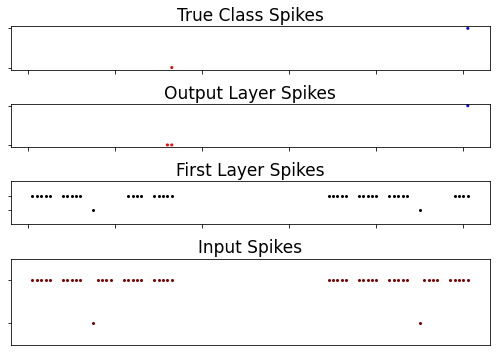

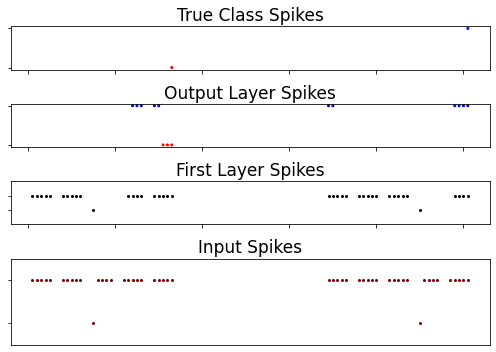

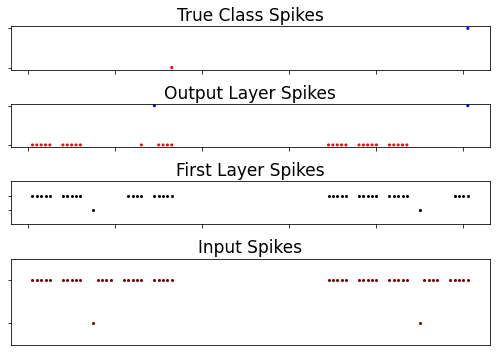

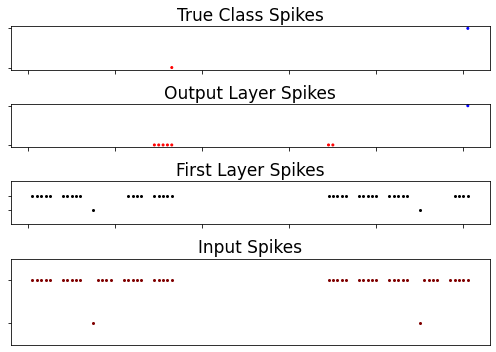

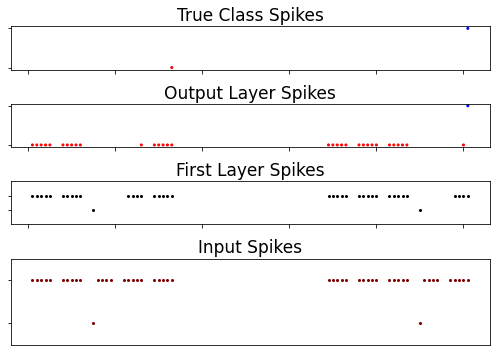

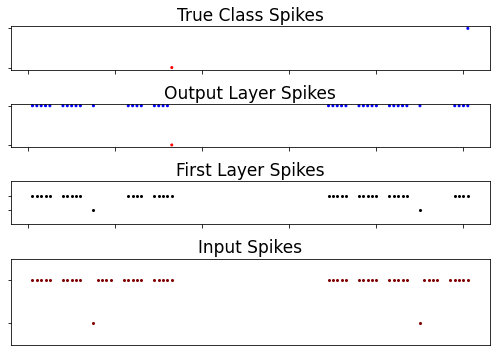

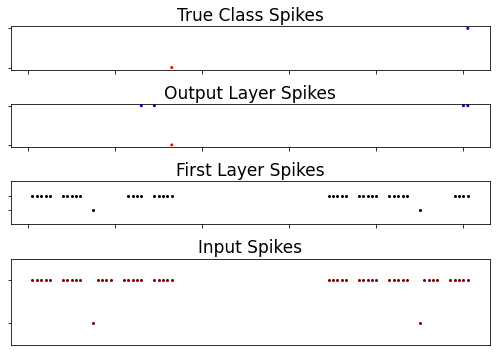

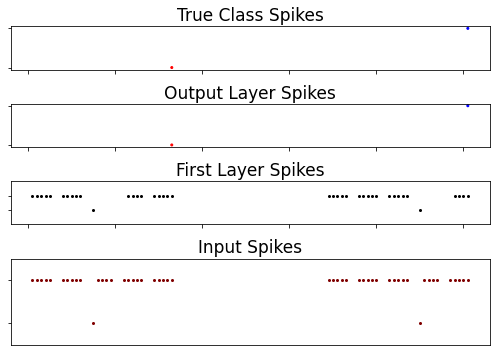

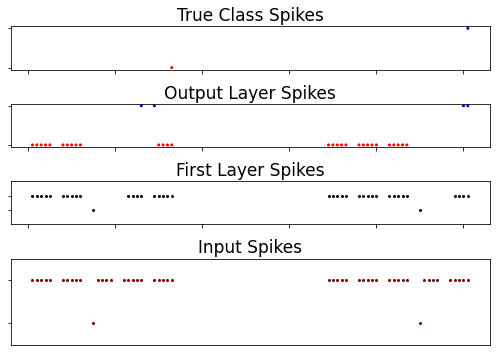

In [15]:
fontsize = 17
dot_size = 5
for plot in range(9):
    data_plot = data_plots[plot]
    first_plot = first_plots[plot]
#     second_plot = second_plots[plot]
    output_plot = output_plots[plot]
    true_plot = true_plots[plot]


    fig, axs = plt.subplots(4, 1, sharex=True ,gridspec_kw={'height_ratios': [output_layer_n_classes,output_layer_n_classes*output_layer_n_neurons_per_class,first_layer_n_neurons,dim+2]},figsize=(7,5))


    if len(true_plot) > 0:
        colors = pltcolor(true_plot)
        true_plot = np.asarray(true_plot)
        axs[0].scatter(true_plot[:,1],true_plot[:,0],s=4,c=colors)
        axs[0].yaxis.set_ticks(np.arange(0,output_layer_n_classes,1))
        axs[0].tick_params(axis='y',left=True,labelleft=False)
        axs[0].title.set_text('True Class Spikes')
        axs[0].title.set_fontsize(fontsize)
#         axs[0].legend()

    if len(output_plot) > 0:
        colors = pltcolor(output_plot)
        output_plot = np.asarray(output_plot)
        axs[1].scatter(output_plot[:,1],output_plot[:,0],s=4,c=colors)
        axs[1].yaxis.set_ticks(np.arange(0,output_layer_n_classes,1))
        
        axs[1].tick_params(axis='y',left=True,labelleft=False)
        axs[1].title.set_text('Output Layer Spikes')
        axs[1].title.set_fontsize(fontsize)

#     if len(second_plot) > 0:
#         second_plot = np.asarray(second_plot)
#         axs[2].scatter(second_plot[:,1],second_plot[:,0],s=4,c='black')
#         axs[2].tick_params(axis='y',left=False,labelleft=False)
#         axs[2].title.set_text('Second Layer Spikes')

    if len(first_plot) > 0:
        first_plot = np.asarray(first_plot)
        axs[2].scatter(first_plot[:,1],first_plot[:,0],s=4,c='black')
        axs[2].yaxis.set_ticks(np.arange(0,first_layer_n_neurons,1))
        
        axs[2].tick_params(axis='y',left=True,labelleft=False)
        axs[2].set_ylim(-1,first_layer_n_neurons)
        axs[2].title.set_text('First Layer Spikes')
        axs[2].title.set_fontsize(fontsize)

    if len(data_plot) > 0:
        data_plot = np.asarray(data_plot)
        axs[3].scatter(data_plot[:,1],data_plot[:,0],s=4,c='maroon')
        axs[3].yaxis.set_ticks(np.arange(0,2,1))
        
        axs[3].tick_params(axis='both',left=True,labelleft=False,bottom=False,labelbottom=False)
        axs[3].set_ylim(-0.5,1.5)
        axs[3].title.set_text('Input Spikes')
        axs[3].title.set_fontsize(fontsize)
        
#     fig.legend( legend_elements, loc = 'right', ncol=1 )
    fig.tight_layout()
    


# plt.xlim([319000,328000])
    

In [71]:
plt.savefig("00100_00010_detection.svg", format="svg")

In [10]:

plot_dictionary = dict()
plot_dictionary['data'] = data_plots
plot_dictionary['first'] = first_plots
plot_dictionary['output'] = output_plots
plot_dictionary['true'] = true_plots

import pickle


with open('plot_0_1_detection.pickle', 'wb') as handle:
    pickle.dump(plot_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [11]:
with open('plot_0_1_detection.pickle', 'rb') as handle:
    b = pickle.load(handle)


In [12]:
b.keys()


dict_keys(['data', 'first', 'output', 'true'])

In [ ]:
b['data']